In [ ]:
# import module
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from cutmix_keras import CutMixImageDataGenerator # CutMix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [ ]:
# define image size and hyperparameters
img_width = 256
img_height = 256
batch_size = 8
epoch = 100

In [ ]:
# data augmentation for training data
TRAINING_DIR = 'train'

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   rotation_range = 30,
                                   zoom_range = 0.4,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)
print('train: ',end='')
'''
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    target_size = (img_height, img_width),
                                                    shuffle = True,
                                                    subset= 'training')
'''

# iterator 1
train_iterator1 = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    target_size = (img_height, img_width),
                                                    shuffle = True,
                                                    subset= 'training')
# iterator 2
train_iterator2 = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    target_size = (img_height, img_width),
                                                    shuffle = True,
                                                    subset= 'training')
# train data generator
train_generator = CutMixImageDataGenerator(generator1=train_iterator1,
                                           generator2=train_iterator2,
                                           img_size = img_height,
                                           batch_size = batch_size,)

# validation data
print('validation: ',end='')
validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        target_size = (img_height, img_width),
                                                        shuffle = False,
                                                        subset= 'validation')

train: Found 840 images belonging to 4 classes.
Found 840 images belonging to 4 classes.
validation: Found 208 images belonging to 4 classes.


In [ ]:
# eraly stopping
callbacks = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'auto')
# autosave best model
best_model_file = 'best_weights.h5'
best_model = ModelCheckpoint(best_model_file, monitor = 'val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
# model
model = Sequential([
    Conv2D(16, (3, 3), activation = 'relu', input_shape = (img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(4, activation = 'softmax')
])
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [ ]:
history = model.fit_generator(train_generator,
                              epochs = epoch,
                              steps_per_epoch = train_generator.get_steps_per_epoch(),
                              verbose = 1,
                              validation_data = validation_generator,
                              callbacks = [best_model]
                              )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
105/105 [==============================] - ETA: 0s - loss: 1.1175 - accuracy: 0.5143
Epoch 1: val_accuracy improved from -inf to 0.76923, saving model to best_weights.h5
105/105 [==============================] - 187s 2s/step - loss: 1.1175 - accuracy: 0.5143 - val_loss: 0.8071 - val_accuracy: 0.7692
Epoch 2/100
105/105 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.6583
Epoch 2: val_accuracy did not improve from 0.76923
105/105 [==============================] - 100s 955ms/step - loss: 0.9559 - accuracy: 0.6583 - val_loss: 0.8049 - val_accuracy: 0.5962
Epoch 3/100
105/105 [==============================] - ETA: 0s - loss: 0.9294 - accuracy: 0.6762
Epoch 3: val_accuracy did not improve from 0.76923
105/105 [==============================] - 100s 957ms/step - loss: 0.9294 - accuracy: 0.6762 - val_loss: 0.7504 - val_accuracy: 0.6202
Epoch 4/100
105/105 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.6798
Epoch 4: val_accuracy d

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

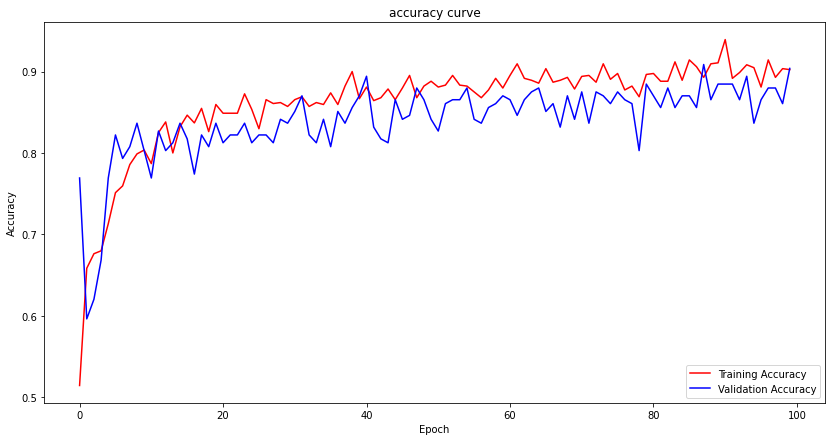

In [ ]:
# plot accuracy
fig = plt.figure(figsize = (14,7))
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right') # label location
plt.title('accuracy curve') 
plt.show()

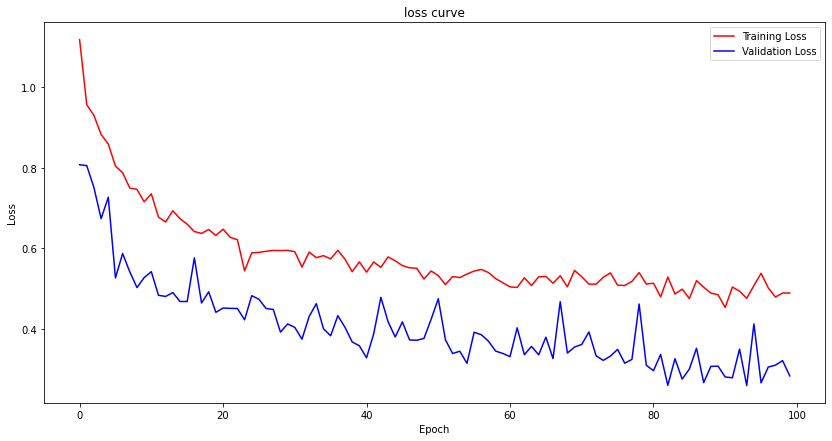

In [ ]:
# plot loss
epochs = range(len(acc))
fig2 = plt.figure(figsize = (14,7))
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right') # label location
plt.title('loss curve')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


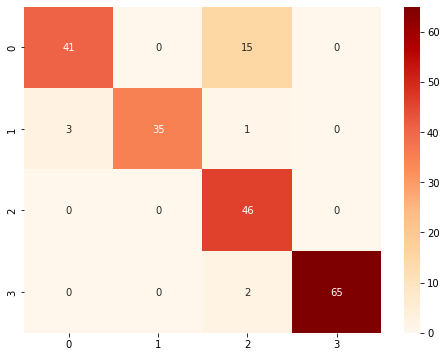

In [ ]:
# confusion metrix of validation data
y = validation_generator.classes
y_hat = model.predict_generator(validation_generator)
pre = np.argmax(y_hat, axis=1)
res = confusion_matrix(y, pre)
fig = plt.figure(figsize=(8, 6))
sn.heatmap(res, annot=True, cmap="OrRd", fmt='g')

In [ ]:
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a /= 255.
    return a

TEST_DIR = 'test'

# sort image filename in testing data
testing_img = os.listdir(TEST_DIR+'/')
testing_img.sort(key = lambda x: int(x[:-4]))

test_images = [TEST_DIR + '/' + item for item in testing_img]
test_preprocessed_images = np.vstack([preprocess_image(fn) for fn in test_images])
# image to array for input type
np.save('test_preproc_CNN.npy', test_preprocessed_images)

In [ ]:
# predict grading data
array = model.predict(test_preprocessed_images, batch_size=1, verbose=1)
result = np.argmax(array, axis=1)

75/75 [==============================] - 2s 27ms/step


In [ ]:
# save predict result to df
df = pd.DataFrame()

df['image_id'] = testing_img
df['labels'] = result

# output csv file
df.to_csv("submission.csv", index = False)